<font size=6 color=#*000000* >7370FinalProject

<font size=6 color=#*000000* >Enhanced Garbage Image Recognition System

<font size=5 color=#*000000* >Part1. Use CNN to build the Trash Detection Network

WeiChen 001562214 | YanXuan 001563047 | YiqingWang 001563190

The Dataset from Kaggle: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

<font size=4 color=#*000000* >Motivation: 

Due to the rapid development of cities, the amount of garbage is increasing. If it is not sorted and recycled, it will have a bad impact on people's health and living environment.

<font size=4 color=#*000000* >Target: 

The key to efficient waste management is to ensure proper sorting of waste and to ensure that the waste goes through different streams of recycling and resource recovery

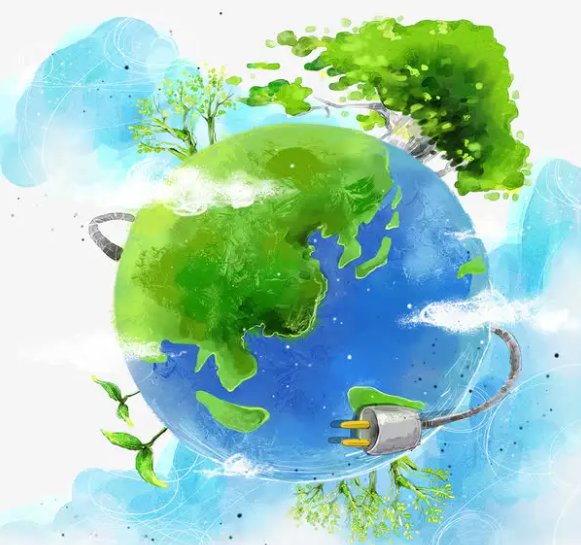

<font size=6 color=#*000000* >Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.utils.image_utils import img_to_array, load_img, array_to_img
from keras.preprocessing.image import ImageDataGenerator
import random,os,glob
import matplotlib.pyplot as plt
from tqdm import tqdm

<font size=6 color=#*000000* >Load Dataset and Show

<font size=4 color=#*000000* >Load Data

In [ ]:
# We uploaded the dataset to Google Drive for loading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the location of dataset in Google Drive
dir_path = 'drive/My Drive/7370/Garbage classification/Garbage classification'

In [ ]:
# The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))

In [ ]:
# See if data loaded successfully
len(img_list)

2527

<font size=4 color=#*000000* >Show Data

See how many classes and items in each class

In [ ]:
total_dir = len(os.listdir(dir_path))
total_files = 0

for dirname, _, filenames in os.walk(dir_path):
    print('counting:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('total files in dir:', files_counter)

print('total number of files',total_files)
print('total number of directories',total_dir)

counting: drive/My Drive/7370/Garbage classification/Garbage classification
total files in dir: 0
counting: drive/My Drive/7370/Garbage classification/Garbage classification/cardboard
total files in dir: 403
counting: drive/My Drive/7370/Garbage classification/Garbage classification/glass
total files in dir: 501
counting: drive/My Drive/7370/Garbage classification/Garbage classification/paper
total files in dir: 594
counting: drive/My Drive/7370/Garbage classification/Garbage classification/trash
total files in dir: 137
counting: drive/My Drive/7370/Garbage classification/Garbage classification/metal
total files in dir: 410
counting: drive/My Drive/7370/Garbage classification/Garbage classification/plastic
total files in dir: 482
--------
total number of files 2527
total number of directories 6


We then want to visualize some original items from the dataset

In [ ]:
# We split the dataset here, but thought is not good enough, so we changed the split in the following
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    validation_split=0.2,
    subset='training',
    seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
# get class names
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


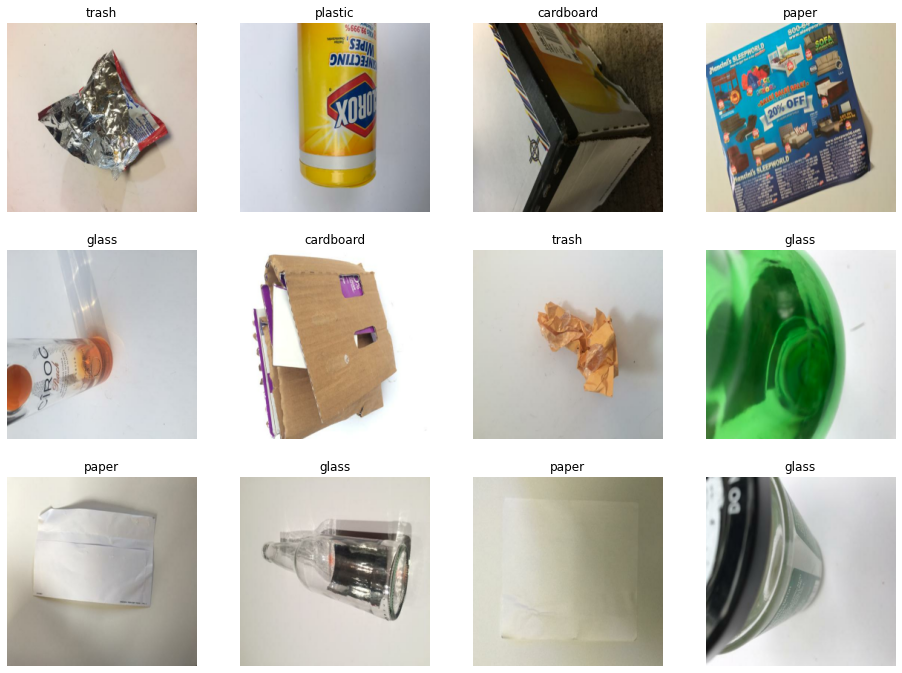

In [ ]:
# view the first few images from the dataset
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

We want to visualize the distribution of the dataset further

In [ ]:
# We want to visualize the distribution of classes using a pie chart

x_data = [] 
y_data = [] 

for category in glob.glob(dir_path+'/*'):
    for file in tqdm(glob.glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 482/482 [00:02<00:00, 202.38it/s]


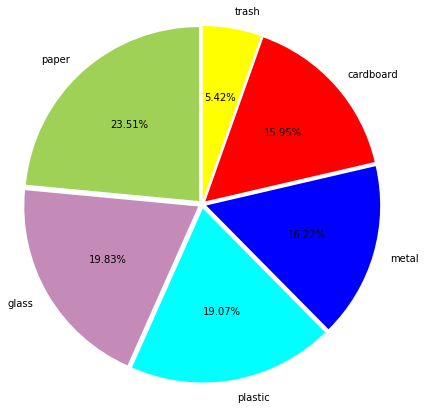

In [ ]:
colors = ['#a0d157','#c48bb8','cyan','blue','red','yellow']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05,0.05,0.05],autopct='%0.2f%%',
        labels=['paper', 'glass','plastic','metal','cardboard','trash'], colors= colors,radius=2)
plt.show()

<font size=6 color=#*000000* >Preprocessing of Dataset

Firstly we use ImageDataGenerator to generate batches of tensor image data with real-time data augmentation.

In [ ]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

# Use numbers instead of feature names
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [ ]:
# Show the shape of image_batch and label_batch
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

Write the file of labels

In [ ]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


<font size=6 color=#*000000* >Building CNN Network and Saving keras model

<font size=4 color=#*000000* >Why use CNN?

Convolutional Neural Networks also known as CNNs or ConvNets, are a type of feed-forward artificial neural network whose connectivity structure is inspired by the organization of the animal visual cortex. Small clusters of cells in the visual cortex are sensitive to certain areas of the visual field. Individual neuronal cells in the brain respond or fire only when certain orientations of edges are present. Some neurons activate when shown vertical edges, while others fire when shown horizontal or diagonal edges. A convolutional neural network is a type of artificial neural network used in deep learning to evaluate visual information. These networks can handle a wide range of tasks involving images, sounds, texts, videos, and other media.

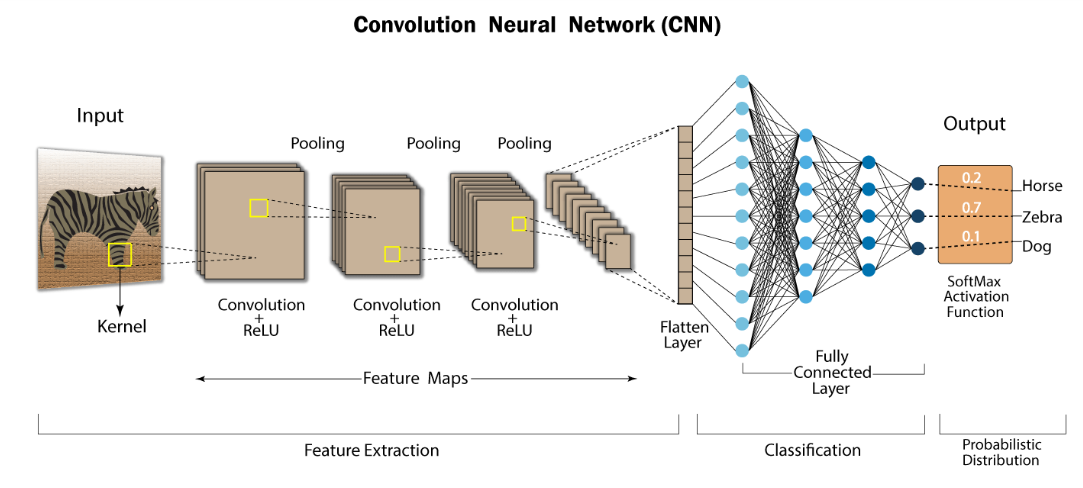

Convolutional Neural Networks (CNNs) have an input layer, an output layer, numerous hidden layers, and millions of parameters, allowing them to learn complicated objects and patterns. It uses convolution and pooling processes to sub-sample the given input before applying an activation function, where all of them are hidden layers that are partially connected, with the completely connected layer at the end resulting in the output layer. The output shape is similar to the size of the input image.


Convolution is the process of combining two functions to produce the output of the other function. The input image is convoluted with the application of filters in CNNs, resulting in a Feature map. Filters are weights and biases that are randomly generated vectors in the network. Instead of having individual weights and biases for each neuron, CNN uses the same weights and biases for all neurons. Many filters can be created, each of which catches a different aspect from the input. Kernels are another name for filters.

In [ ]:
model=Sequential()

#Convolution blocks
model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

<font size=4 color=#*000000* >Summarizing the CNN model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0

<font size=4 color=#*000000* >Compiling the CNN model

In [ ]:
# Compiling CNN model using categorical cross entropy loss function and adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

<font size=4 color=#*000000* >Training the CNN model

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                              callbacks=callbacks_list)

<ipython-input-16-c26c4a431e4d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.7791 - acc: 0.2014
Epoch 1: val_acc improved from -inf to 0.23214, saving model to trained_model.h5
71/71 [==============================] - 337s 4s/step - loss: 1.7791 - acc: 0.2014 - val_loss: 1.7034 - val_acc: 0.2321
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.7420 - acc: 0.2380
Epoch 2: val_acc improved from 0.23214 to 0.25893, saving model to trained_model.h5
71/71 [==============================] - 41s 549ms/step - loss: 1.7420 - acc: 0.2380 - val_loss: 1.6761 - val_acc: 0.2589
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.6077 - acc: 0.3151
Epoch 3: val_acc improved from 0.25893 to 0.33036, saving model to trained_model.h5
71/71 [==============================] - 41s 550ms/step - loss: 1.6077 - acc: 0.3151 - val_loss: 1.5564 - val_acc: 0.3304
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 1.5025 - acc: 0.3690
Epoch 4: val_acc improved f

<font size=6 color=#*000000* >The Performence of the CNN Model

We use prediction of the CNN model compared with test set to see the performance

1/1 [==============================] - 0s 15ms/step
Maximum Probability:  0.9678255
Classified: plastic


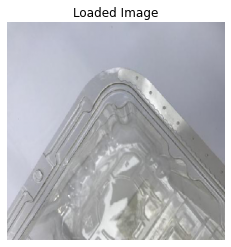

In [ ]:
# Firstly show randomly one image for testing

img_path = 'drive/My Drive/7370/Garbage classification/Garbage classification/plastic/plastic39.jpg'

img = load_img(img_path, target_size=(300, 300))
img = img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

From above, we see the accuracy of the most possible prediction offered by the model. What's the model's accurate predictions? We showed below.

CARDBOARD : 0.29 %
GLASS : 0.27 %
METAL : 0.0 %
PAPER : 2.61 %
PLASTIC : 96.78 %
TRASH : 0.04 %


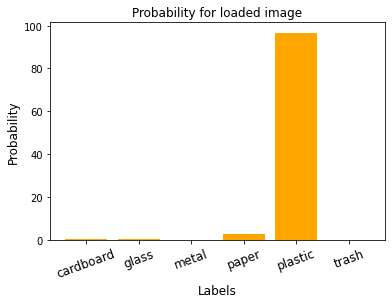

In [ ]:
classes=[]
prob=[]

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob,color='orange')
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

We then want to see more results

1/1 [==============================] - 0s 20ms/step
CARDBOARD : 0.0 %
GLASS : 0.01 %
METAL : 0.0 %
PAPER : 0.04 %
PLASTIC : 99.95 %
TRASH : 0.0 %
Maximum Probability:  0.9995246
Classified: plastic
1/1 [==============================] - 0s 15ms/step
CARDBOARD : 0.46 %
GLASS : 1.88 %
METAL : 0.01 %
PAPER : 0.02 %
PLASTIC : 97.6 %
TRASH : 0.03 %
Maximum Probability:  0.9759578
Classified: plastic
1/1 [==============================] - 0s 18ms/step
CARDBOARD : 0.0 %
GLASS : 0.1 %
METAL : 0.0 %
PAPER : 0.0 %
PLASTIC : 99.9 %
TRASH : 0.0 %
Maximum Probability:  0.9989502
Classified: plastic
1/1 [==============================] - 0s 16ms/step
CARDBOARD : 4.63 %
GLASS : 18.66 %
METAL : 0.38 %
PAPER : 0.33 %
PLASTIC : 75.76 %
TRASH : 0.25 %
Maximum Probability:  0.75756973
Classified: plastic
1/1 [==============================] - 0s 17ms/step
CARDBOARD : 0.04 %
GLASS : 0.16 %
METAL : 0.0 %
PAPER : 0.07 %
PLASTIC : 99.72 %
TRASH : 0.0 %
Maximum Probability:  0.99721515
Classified: plastic
1/1 

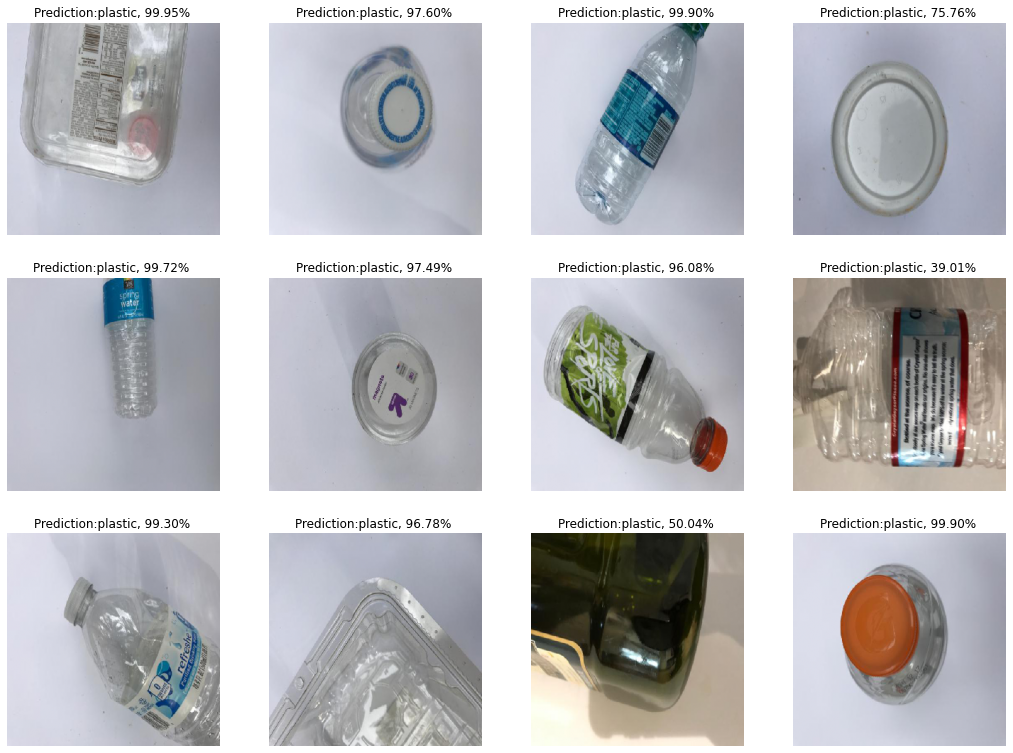

In [ ]:
# show imgs and labels
plt.figure(figsize=(18, 18))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    index = str(i+30)
    img_path = 'drive/My Drive/7370/Garbage classification/Garbage classification/plastic/plastic'+index+'.jpg'
    
    img = load_img(img_path, target_size=(300, 300))
    img = img_to_array(img, dtype=np.uint8)
    img=np.array(img)/255.0

    plt.imshow(img.squeeze())

    p=model.predict(img[np.newaxis, ...])

    classes=[]
    prob=[]

    for i,j in enumerate (p[0],0):
      print(labels[i].upper(),':',round(j*100,2),'%')
      classes.append(labels[i])
      prob.append(round(j*100,2))
    
    plt.imshow(img)
    print("Maximum Probability: ",np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:",predicted_class)
    plt.title('Prediction:{}, {:.2f}% '.format(predicted_class, 100*np.max(p[0])))
    plt.axis("off")

Then we use Accuracy Graph and Loss Graph to measure the performance of the model

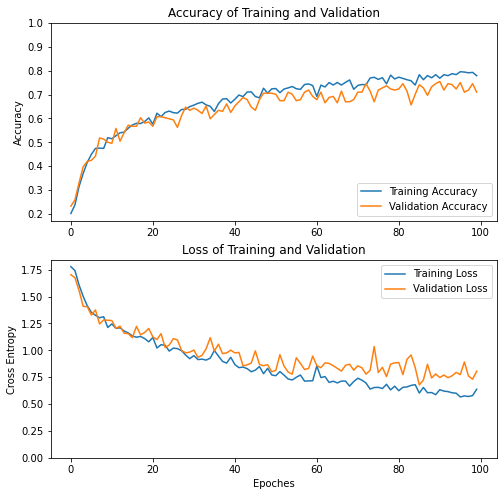

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy of Training and Validation Graph
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy of Training and Validation')

# Loss of Training and Validation Graph
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoches')
plt.ylim([0,max(plt.ylim())])
plt.title('Loss of Training and Validation')
plt.show()

Finally we want to see the accuracy score of our trained model

In [ ]:
acc = accuracy_score(test_generator.classes, y_pred)
print("Accuracy is {} percent".format(round(acc*100,2)))

Accuracy is 76.26 percent


Converting to TFLite

In [ ]:
# The TensorFlow Lite converter takes a TensorFlow model 
# and generates a TensorFlow Lite model (an optimized FlatBuffer format identified by the .tflite file extension)
# You can load a SavedModel or directly convert a model you create in code.

import tensorflow as tf
model=tf.keras.models.load_model("Garbage.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model) 

11380020

<font size=6 color=#*000000* >Conclusion

In this final project, we present, split, and test a dataset of more than 2000 images across six categories. We used CNN and YOLOv5 structure for model training. In the simulation prediction of the CNN model, we visualize the prediction effect of the model according to the prediction accuracy of the training model, and see the specific process of model training and the final performance of the model according to the model Accuracy and Loss of Training and Validation chart. We can see that the accuracy of the model is finally about 0.76. After comparing with other documents, it is found that the accuracy of the CNN network based on this data set is indeed not that high, and the accuracy of 0.76 is already a relatively excellent score.

According to our data segmentation and model training, the final accuracy of the CNN-based model did not meet expectations. After searching for information, it is found that the dataset performs well in ResNet, but there are also problems such as insufficient CNN layer settings, insufficient number of epochs, and insufficient training set data. This brings us to the importance of choosing a model and a richer dataset.

<font size=6 color=#*000000* >Reference 

[1]tf.keras.preprocessing.image.ImageDataGenerator, https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

[2]Classifying Recycling Material, https://www.kaggle.com/code/olmaneuh/classifying-recycling-material

[3]Basics of CNN in Deep Learning, https://www.analyticsvidhya.com/blog/2022/03/basics-of-cnn-in-deep-learning/

[4]Trash Management System, https://www.kaggle.com/code/maninair/trash-management-system

[5]Model conversion overview, https://www.tensorflow.org/lite/models/convert


<font size=6 color=#*000000* >Licensing
    
Copyright 2022 Wei Chen, Yan Xuan, Yiqing Wang

Persons who have obtained a copy of the software and associated documentation files may use the software free of charge without restriction. Publish, distribute, sublicense and/or sell copies of the software, subject to the following conditions:

THIS SOFTWARE IS PROVIDED "AS IS" WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NON-INFRINGEMENT WARRANTIES. 
    
In no event shall the author or copyright holder be liable for any claim, damage or other liability, whether in contract, tort or otherwise, arising out of or in connection with the software or its use or other dealings. software.